In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Install libs (rasterio for TIFF, matplotlib for viz, label-studio for manual labeling)
!pip install rasterio label-studio albumentations torch torchvision torchaudio segmentation-models-pytorch timm datasets transformers

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.7 MB/s eta 0:00:00
   ━━━━

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from segmentation_models_pytorch import Unet
from timm import create_model
from datasets import Dataset as HFDataset
from huggingface_hub import login  # For pushing model/datasets

View sample bands: RGB (bands 3-1-2), NDVI (band 5). Pairs Before/After by index (e.g., Jan 2020 vs Jan 2023).




In [ ]:
# List files (0-5: Before, 6-11: After)
tiff_paths = sorted(glob('/content/drive/MyDrive/GalamseyData/galamsey_*.tif'))
print(f"Loaded {len(tiff_paths)} TIFFs: {tiff_paths}")

Loaded 12 TIFFs: ['/content/drive/MyDrive/GalamseyData/galamsey_0.tif', '/content/drive/MyDrive/GalamseyData/galamsey_1.tif', '/content/drive/MyDrive/GalamseyData/galamsey_10.tif', '/content/drive/MyDrive/GalamseyData/galamsey_11.tif', '/content/drive/MyDrive/GalamseyData/galamsey_2.tif', '/content/drive/MyDrive/GalamseyData/galamsey_3.tif', '/content/drive/MyDrive/GalamseyData/galamsey_4.tif', '/content/drive/MyDrive/GalamseyData/galamsey_5.tif', '/content/drive/MyDrive/GalamseyData/galamsey_6.tif', '/content/drive/MyDrive/GalamseyData/galamsey_7.tif', '/content/drive/MyDrive/GalamseyData/galamsey_8.tif', '/content/drive/MyDrive/GalamseyData/galamsey_9.tif']


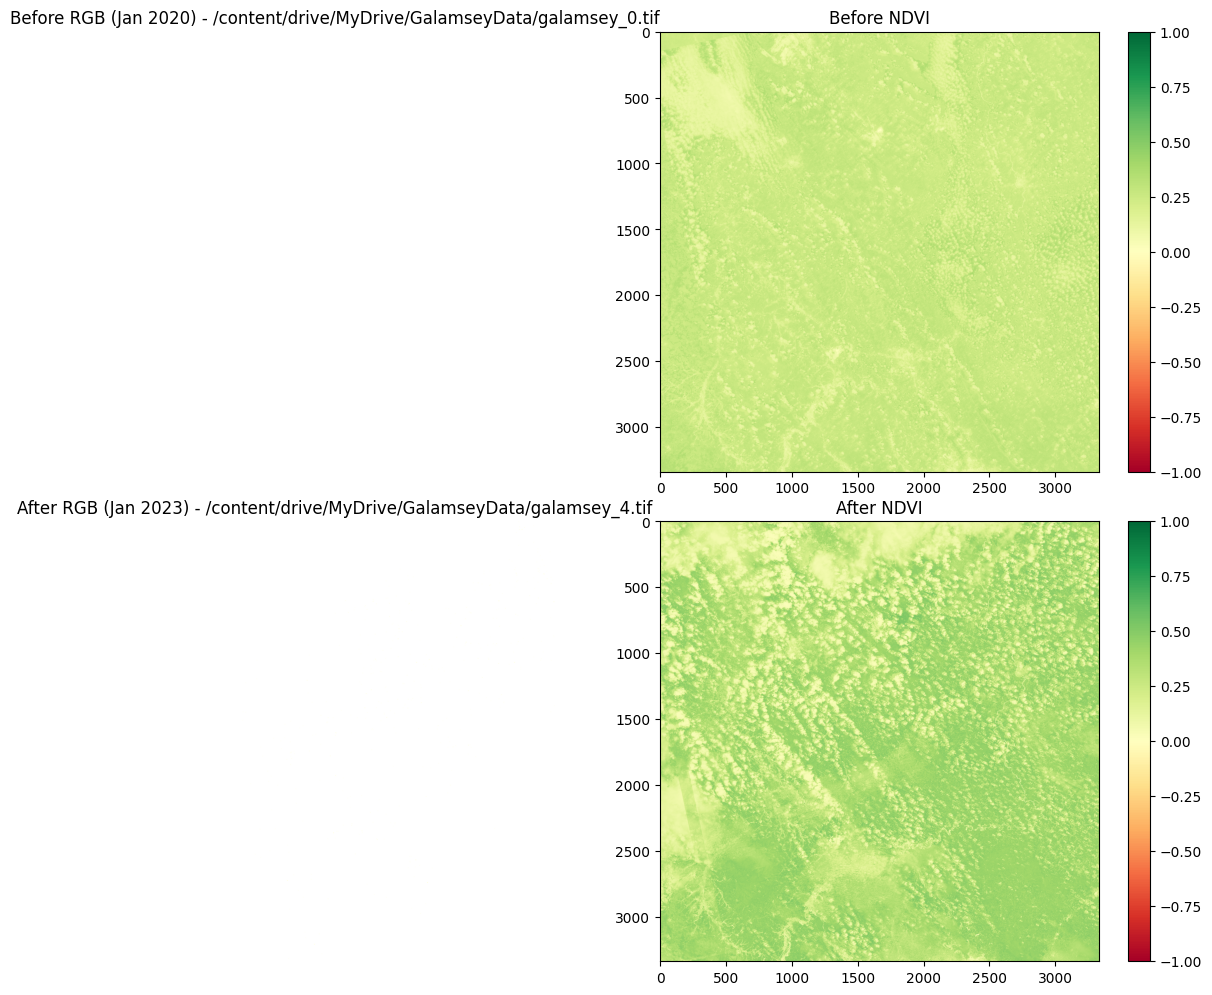

Sample shapes: (3, 3339, 3335) (3339, 3335)


In [ ]:
# Function to load & normalize tile (8 bands: 0=blue,1=green,2=red,3=nir,4=ndvi,5=avg_rad,6=VV,7=VH)
def load_tiff(path, band_slice=None):
    with rasterio.open(path) as src:
        data = src.read()  # (8, H, W)
        if band_slice:
            data = data[band_slice]
        data = np.clip(data, 0, 1)  # Normalize [0,1]
    return data

# Visualize samples: Plot RGB & NDVI for idx 0 (Before Jan 2020) & 6 (After Jan 2023)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
idx_before, idx_after = 0, 6

# Before RGB
rgb_b = load_tiff(tiff_paths[idx_before], [2,1,0])  # Red=2, Green=1, Blue=0
axs[0,0].imshow(np.transpose(rgb_b, (1,2,0)))
axs[0,0].set_title(f'Before RGB (Jan 2020) - {tiff_paths[idx_before]}')
axs[0,0].axis('off')

# Before NDVI
ndvi_b = load_tiff(tiff_paths[idx_before], [4])[0]  # Band 4
im_b = axs[0,1].imshow(ndvi_b, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0,1].set_title('Before NDVI')
plt.colorbar(im_b, ax=axs[0,1])

# After RGB
rgb_a = load_tiff(tiff_paths[idx_after], [2,1,0])
axs[1,0].imshow(np.transpose(rgb_a, (1,2,0)))
axs[1,0].set_title(f'After RGB (Jan 2023) - {tiff_paths[idx_after]}')
axs[1,0].axis('off')

# After NDVI
ndvi_a = load_tiff(tiff_paths[idx_after], [4])[0]
im_a = axs[1,1].imshow(ndvi_a, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1,1].set_title('After NDVI')
plt.colorbar(im_a, ax=axs[1,1])

plt.tight_layout()
plt.show()

# Quick stats
print("Sample shapes:", rgb_b.shape, ndvi_b.shape)

#Pair Before/After Tiles for Change Detection


Tile full TIFFs to 256x256 (non-overlapping). Pair by month (e.g., 0 with 6). ~100-200 pairs total (small area = fewer tiles).



In [ ]:
from rasterio.windows import Window

# Tile function: Extract 256x256 patches
def tile_tiff(path, tile_size=256):
    with rasterio.open(path) as src:
        h, w = src.height, src.width
        tiles = []
        for i in range(0, h, tile_size):
            for j in range(0, w, tile_size):
                win = Window(j, i, min(tile_size, w-j), min(tile_size, h-i))
                tile = src.read(window=win)  # (8, 256, 256)
                if tile.shape[1] == tile_size and tile.shape[2] == tile_size:  # Full tiles only
                    tiles.append({'data': tile, 'path': path, 'i': i//256, 'j': j//256})
    return tiles

# Generate paired tiles (Before i pairs with After i+6)
paired_tiles = []
for i in range(6):  # 6 months
    before_tiles = tile_tiff(tiff_paths[i])
    after_tiles = tile_tiff(tiff_paths[i+6])
    # Assume same # tiles; pair spatially (same i,j)
    for bt in before_tiles:
        at = next((t for t in after_tiles if t['i']==bt['i'] and t['j']==bt['j']), None)
        if at:
            paired_tiles.append({'before': bt['data'], 'after': at['data'], 'label': None, 'pos': (bt['i'], bt['j'])})

print(f"Generated {len(paired_tiles)} paired tiles for labeling/training.")
# Save pairs as NPZ for efficiency (optional)
np.savez_compressed('/content/drive/MyDrive/GalamseyData/paired_tiles.npz', paired_tiles=paired_tiles)

Generated 1014 paired tiles for labeling/training.


#Labeling Planning – Rule-Based Labeling (Applied to All Pairs)


Flag change if NDVI drops >0.2 (mining scars) or VIIRS >10 (night activity). Binary mask (1=change). Scientifically grounded: NDVI for veg loss (e.g., Hansen et al. 2013), VIIRS for human footprint (Elvidge et al. 2017).





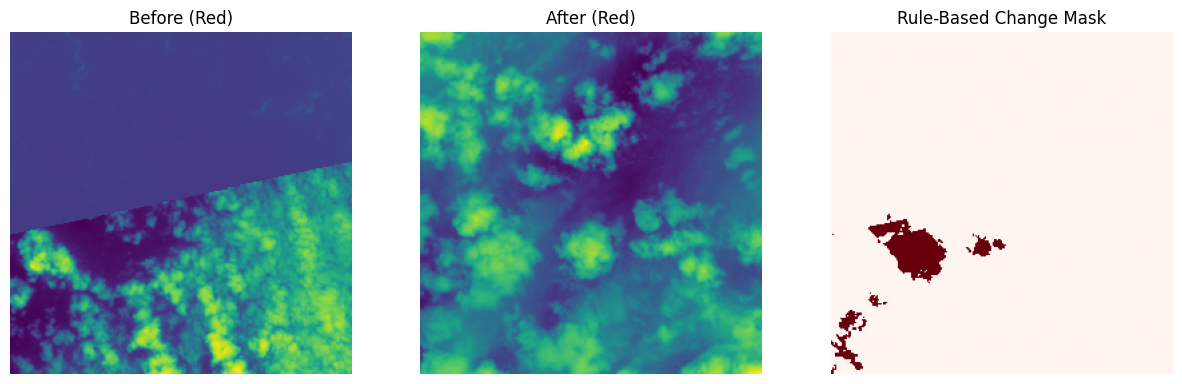

Rule-based labels generated for all pairs. Avg % change pixels: 0.10934454


In [ ]:
# Load pairs from above (or NPZ)
# paired_tiles = ...  # From Section 3

def rule_based_label(before, after, ndvi_thresh=0.2, viirs_thresh=10):
    ndvi_b = before[4]  # NDVI before
    ndvi_a = after[4]   # NDVI after
    viirs_a = after[5]  # Nightlights after

    # Change mask: NDVI drop OR nightlights increase
    change_ndvi = (ndvi_b - ndvi_a) > ndvi_thresh
    change_viirs = viirs_a > viirs_thresh  # Absolute thresh (adjust based on viz)
    mask = np.logical_or(change_ndvi, change_viirs).astype(np.float32)

    return mask  # (256,256) binary

# Demo on first pair
sample_pair = paired_tiles[0]
mask = rule_based_label(sample_pair['before'], sample_pair['after'])

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(sample_pair['before'][2])  # Before RGB (red channel for simplicity)
axs[0].set_title('Before (Red)')
axs[1].imshow(sample_pair['after'][2])
axs[1].set_title('After (Red)')
axs[2].imshow(mask, cmap='Reds')
axs[2].set_title('Rule-Based Change Mask')
for ax in axs: ax.axis('off')
plt.show()

# Apply to all (save masks)
for p in paired_tiles:
    p['label'] = rule_based_label(p['before'], p['after'])

print("Rule-based labels generated for all pairs. Avg % change pixels:", np.mean([np.mean(p['label']) for p in paired_tiles]))
# Save updated pairs
np.savez_compressed('/content/drive/MyDrive/GalamseyData/paired_tiles_labeled.npz', paired_tiles=paired_tiles)

In [ ]:
# Full reload & fixes (run as one cell)
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import functional as F
import albumentations as A
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler  # Fixed deprecation

# Focal Loss for sparse positives
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal.mean()

# Reload labeled pairs
paired_tiles = np.load('/content/drive/MyDrive/GalamseyData/paired_tiles_labeled.npz', allow_pickle=True)['paired_tiles']
print(f"Reloaded {len(paired_tiles)} pairs.")

# Subset if OOM (uncomment)
# paired_tiles = paired_tiles[:400]
# print(f"Subset to {len(paired_tiles)} pairs.")

class GalamseyDataset(Dataset):
    def __init__(self, paired_tiles, transform=None):
        self.pairs = paired_tiles
        self.transform = transform or A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ], is_check_shapes=False)  # Fixed: Disable check for flips

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        before = self.pairs[idx]['before'].copy()
        after = self.pairs[idx]['after'].copy()
        mask = self.pairs[idx]['label'].copy()

        stacked = np.concatenate([before, after], axis=0)

        if self.transform:
            transformed = self.transform(image=stacked, mask=mask[:, :, np.newaxis])
            stacked = transformed['image']
            mask = transformed['mask'].squeeze(-1)  # Fixed: Squeeze after to (H,W)

        return torch.from_numpy(stacked).float(), torch.from_numpy(mask).unsqueeze(0).float()

# Split
train_size = int(0.8 * len(paired_tiles))
train_ds = GalamseyDataset(paired_tiles[:train_size])
val_ds = GalamseyDataset(paired_tiles[train_size:])

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=0, pin_memory=False)

print(f"Dataset ready: {len(train_ds)} train, {len(val_ds)} val pairs.")

# Model
class SiameseUnet(nn.Module):
    def __init__(self, num_channels=16):
        super().__init__()
        self.unet = Unet(
            encoder_name='efficientnet-b0',
            encoder_weights='imagenet',
            in_channels=num_channels,
            classes=1,
            activation=None
        )

    def forward(self, x):
        return self.unet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")
model = SiameseUnet().to(device)
optimizer = AdamW(model.parameters(), lr=5e-6)
criterion = FocalLoss()  # Focal for sparse
scaler = GradScaler('cuda')

# Data debug
sample_input, sample_mask = next(iter(train_loader))
print(f"Input min/max/NaN: {sample_input.min():.3f}/{sample_input.max():.3f}/{torch.isnan(sample_input).any()}")
print(f"Mask min/max/NaN/pos%: {sample_mask.min():.3f}/{sample_mask.max():.3f}/{torch.isnan(sample_mask).any()}/{torch.mean(sample_mask).item():.3f}")

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0
    valid_batches = 0
    for batch_idx, (inputs, masks) in enumerate(train_loader):
        inputs, masks = inputs.to(device, non_blocking=True), masks.to(device, non_blocking=True)

        if torch.all(masks == 0):
            continue

        inputs = torch.clamp(inputs, 0, 1)
        inputs = (inputs - inputs.mean()) / (inputs.std() + 1e-8)

        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, masks)

            if torch.isnan(loss):
                print(f"NaN batch {batch_idx}—skip")
                continue

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        valid_batches += 1

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
            torch.cuda.empty_cache()

    if valid_batches > 0:
        avg_train_loss = train_loss / valid_batches
        print(f"Epoch {epoch+1} Avg Loss: {avg_train_loss:.4f}")

    # Val every 5 (no Dice here—separate cell)
    if (epoch + 1) % 5 == 0:
        model.eval()
        val_loss = 0
        valid_val = 0
        with torch.no_grad(), autocast('cuda'):
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                if torch.all(masks == 0):
                    continue
                inputs = torch.clamp(inputs, 0, 1)
                inputs = (inputs - inputs.mean()) / (inputs.std() + 1e-8)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                if not torch.isnan(loss):
                    val_loss += loss.item()
                    valid_val += 1
        if valid_val > 0:
            avg_val_loss = val_loss / valid_val
            print(f"Val Loss: {avg_val_loss:.4f}")
        torch.cuda.empty_cache()

torch.save(model.state_dict(), '/content/drive/MyDrive/GalamseyData/galamsey_unet_focal.pth')
print("Retrained with Focal Loss! Run separate Dice eval for full metrics.")

Reloaded 1014 pairs.
Dataset ready: 811 train, 203 val pairs.
Using: cuda
Input min/max/NaN: -27.741/45991.000/False
Mask min/max/NaN/pos%: 0.000/1.000/False/0.045
Epoch 1/15, Batch 100, Loss: 0.0896
Epoch 1/15, Batch 200, Loss: 0.0864
Epoch 1/15, Batch 300, Loss: 0.0716
Epoch 1/15, Batch 400, Loss: 0.0724
Epoch 1 Avg Loss: 0.0839
Epoch 2/15, Batch 0, Loss: 0.0692
Epoch 2/15, Batch 100, Loss: 0.0616
Epoch 2/15, Batch 200, Loss: 0.0605
Epoch 2/15, Batch 300, Loss: 0.0573
Epoch 2/15, Batch 400, Loss: 0.0528
Epoch 2 Avg Loss: 0.0605
Epoch 3/15, Batch 0, Loss: 0.0497
Epoch 3/15, Batch 100, Loss: 0.0457
Epoch 3/15, Batch 200, Loss: 0.0443
Epoch 3/15, Batch 300, Loss: 0.0414
Epoch 3/15, Batch 400, Loss: 0.0365
Epoch 3 Avg Loss: 0.0464
Epoch 4/15, Batch 0, Loss: 0.0422
Epoch 4/15, Batch 100, Loss: 0.0370
Epoch 4/15, Batch 200, Loss: 0.0322
Epoch 4/15, Batch 300, Loss: 0.0357
Epoch 4/15, Batch 400, Loss: 0.0300
Epoch 4 Avg Loss: 0.0365
Epoch 5/15, Batch 0, Loss: 0.0337
Epoch 5/15, Batch 100, L